In [1]:
import torch
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.utils.class_weight import compute_class_weight
from imblearn.combine import SMOTETomek 


class FraudDataset(Dataset):
    """Custom PyTorch Dataset for Fraud Detection"""
    def __init__(self, data, labels):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)  

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]
    
def check_data_leakage(X_train, X_valid, X_test):
    train_df = pd.DataFrame(X_train)
    valid_df = pd.DataFrame(X_valid)
    test_df = pd.DataFrame(X_test)
    
    overlap_train_test = test_df.merge(train_df, how="inner")
    overlap_test_valid = test_df.merge(valid_df, how="inner")
    overlap_train_valid = valid_df.merge(train_df, how="inner")
    
    print(f"Overlapping samples between Train & Test: {len(overlap_train_test)}")
    print(f"Overlapping samples between Validation & Test: {len(overlap_test_valid)}")
    print(f"Overlapping samples between Validation & Train: {len(overlap_train_valid)}")


def add_noise(X_train, mean=0, sigma=0.1):
    """
    Adds Gaussian noise to the training data.
    Args:
        X_train (numpy array): Training features.
        mean (float): Mean of Gaussian noise.
        sigma (float): 
        deviation of noise.

    Returns:
        numpy array: Noisy training features.
    """
    noise = np.random.normal(mean, sigma, X_train.shape)
    return X_train + noise

def get_dataloaders_fraud(csv_path, batch_size=64, num_workers=0, validation_fraction=0.2, use_smote=True, add_noise_flag=True, noise_std=0.1):
    # Load dataset from CSV
    df = pd.read_csv(csv_path)
    
    df.drop_duplicates(inplace=True)
    
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    # Extract features & labels
    X = df.drop(columns=['Class']).values
    y = df['Class'].values
    
    # Standardize features
    scaler = StandardScaler()
    ro_scaler = RobustScaler()
    
    # Compute class weights
    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y.tolist())
    class_weights = torch.tensor(class_weights, dtype=torch.float32)
    
    # First, split into train (64%), validation (16%), and test (20%)
    # This ensures all sets have the same original distribution
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.36, stratify=y, random_state=42)
    X_test, X_valid, y_test, y_valid = train_test_split(X_temp, y_temp, test_size=0.2/0.36, stratify=y_temp, random_state=42)
    
    X_train = ro_scaler.fit_transform(X_train)
    X_valid = ro_scaler.transform(X_valid)
    X_test = ro_scaler.transform(X_test)
    
    
    # Store original train labels
    y_train_before = y_train.copy()
    
    # Apply SMOTE only to training set
    if use_smote:
        print("Applying SMOTE to balance training data...")
        smote = SMOTETomek(sampling_strategy=0.3, random_state=42)
        X_train, y_train = smote.fit_resample(X_train, y_train)
    
    # Add Gaussian Noise to Training Data (After SMOTE)
    if add_noise_flag:
        print(f"Adding Gaussian noise (std={noise_std}) to training data...")
        X_train = add_noise(X_train, sigma=noise_std)
    
    # Ensure variables exist before calling check_data_leakage()
    if X_valid is not None and X_test is not None:
        check_data_leakage(X_train, X_valid, X_test)
    
    # Convert labels to PyTorch-compatible format
    y_train = torch.tensor(y_train, dtype=torch.float32)
    y_valid = torch.tensor(y_valid, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)
    
    # Create PyTorch Datasets
    train_dataset = FraudDataset(X_train, y_train)
    valid_dataset = FraudDataset(X_valid, y_valid)
    test_dataset = FraudDataset(X_test, y_test)
    
    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)
    
    print(f"Training set size after SMOTE: {len(train_dataset)} samples")
    print(f"Validation set size: {len(valid_dataset)} samples")
    print(f"Test set size: {len(test_dataset)} samples")
    
    return train_loader, valid_loader, test_loader

# Set dataset path
DATASET_PATH = "data/creditcard.csv"
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

# Training hyperparameters
batch_size = 64
num_epochs = 10
learning_rate = 0.0003


train_loader, valid_loader, test_loader = get_dataloaders_fraud(
    DATASET_PATH, batch_size=batch_size, use_smote=True
)

Applying SMOTE to balance training data...
Adding Gaussian noise (std=0.1) to training data...
Overlapping samples between Train & Test: 0
Overlapping samples between Validation & Test: 0
Overlapping samples between Validation & Train: 0
Training set size after SMOTE: 235665 samples
Validation set size: 56746 samples
Test set size: 45396 samples


/tmp/ipykernel_9888/1272591377.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(labels, dtype=torch.float32)


In [2]:
df = pd.read_csv('data/creditcard.csv')
# Get the DataFrame without the 'Class' column
df_features = df

# Check for duplicates
duplicates = df_features.duplicated()

# Count how many duplicates exist
num_duplicates = duplicates.sum()

print(f"Number of duplicate rows: {num_duplicates}")

# If you want to see the duplicate rows
if num_duplicates > 0:
    duplicate_rows = df_features[duplicates]
    print(duplicate_rows.head())

Number of duplicate rows: 1081
     Time        V1        V2        V3        V4        V5        V6  \
33   26.0 -0.529912  0.873892  1.347247  0.145457  0.414209  0.100223   
35   26.0 -0.535388  0.865268  1.351076  0.147575  0.433680  0.086983   
113  74.0  1.038370  0.127486  0.184456  1.109950  0.441699  0.945283   
114  74.0  1.038370  0.127486  0.184456  1.109950  0.441699  0.945283   
115  74.0  1.038370  0.127486  0.184456  1.109950  0.441699  0.945283   

           V7        V8        V9  ...       V21       V22       V23  \
33   0.711206  0.176066 -0.286717  ...  0.046949  0.208105 -0.185548   
35   0.693039  0.179742 -0.285642  ...  0.049526  0.206537 -0.187108   
113 -0.036715  0.350995  0.118950  ...  0.102520  0.605089  0.023092   
114 -0.036715  0.350995  0.118950  ...  0.102520  0.605089  0.023092   
115 -0.036715  0.350995  0.118950  ...  0.102520  0.605089  0.023092   

          V24       V25       V26       V27       V28  Amount  Class  
33   0.001031  0.098816 -0

In [3]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score

def compute_metrics(model, data_loader, device, apply_mask=False):
    """
    Compute accuracy, precision, recall, F1-score, and AUC-ROC for a fraud detection model.
    """
    model.eval()
    all_predictions, all_targets, all_probs = [], [], []

    with torch.no_grad():
        for features, targets in data_loader:
            features, targets = features.to(device), targets.to(device)
            targets = targets.view(-1).cpu().numpy()

            logits = model(features, apply_mask=apply_mask)
            probabilities = torch.sigmoid(logits).cpu().numpy().flatten()
            predictions = (probabilities >= 0.5).astype(int)  # Fix: Lowered threshold to 0.5

            all_predictions.extend(predictions)
            all_targets.extend(targets)
            all_probs.extend(probabilities)

    return {
        "accuracy": accuracy_score(all_targets, all_predictions) * 100,
        "precision": precision_score(all_targets, all_predictions, zero_division=0) * 100,
        "recall": recall_score(all_targets, all_predictions, zero_division=0) * 100,
        "f1_score": f1_score(all_targets, all_predictions, zero_division=0) * 100,
        "auc_roc": roc_auc_score(all_targets, all_probs) * 100,
        "auc_pr": average_precision_score(all_targets, all_probs) * 100
        
    }
def evaluate_model(model, test_loader, device):
    """
    Evaluate the model on the test dataset and print key metrics.

    Args:
        model (torch.nn.Module): The trained model to evaluate.
        test_loader (torch.utils.data.DataLoader): DataLoader for the test dataset.
        device (torch.device): Device ('cpu' or 'cuda') to perform computations.
    """
    metrics = compute_metrics(model, test_loader, device)

    print("**Evaluation Results:**")
    print(f"Accuracy   : {metrics['accuracy']:.2f}%")
    print(f"Precision  : {metrics['precision']:.2f}%")
    print(f"Recall     : {metrics['recall']:.2f}%")
    print(f"F1-score   : {metrics['f1_score']:.2f}%")
    print(f"AUC-ROC    : {metrics['auc_roc']:.2f}%")  # New metric
    print(f"AUC-PR    : {metrics['auc_pr']:.2f}%")  # New metric

    return metrics

In [4]:
# Copyright (c) 2023, NVIDIA CORPORATION.  All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import torch
import torch.nn as nn
import torch.nn.functional as F

class FraudNet(nn.Module):
    def __init__(self, input_size, dropout_rate=0.6):
        """
        A fully connected neural network (MLP) for fraud detection.

        Args:
            input_size (int): Number of features in the dataset.
            dropout_rate (float): Dropout probability for regularization.
        """
        super(FraudNet, self).__init__()

        self.fc1 = nn.Linear(input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.fc4 = nn.Linear(32, 1)  # Binary classification output (logits)

        self.dropout = nn.Dropout(dropout_rate)
        self.dropout_rate = dropout_rate

        # Placeholder for stochastic dropout masks
        self.dense_mask = None

    def forward(self, x, apply_mask=False):
        """
        Forward pass through the fraud detection model.

        Args:
            x (torch.Tensor): Input features.
            apply_mask (bool, optional): Whether to apply a dropout mask for Federated Learning. Default is False.

        Returns:
            torch.Tensor: Logits for binary classification (sigmoid will be applied in loss function).
        """
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.relu(self.bn3(self.fc3(x)))

        # if apply_mask and self.dense_mask is not None:
        #     self.dense_mask = self.dense_mask.to(x.device)
        #     x = x * self.dense_mask
        #     x = x / (1 - self.dropout_rate)  # Normalize output

        x = self.fc4(x)  # No sigmoid here! BCEWithLogitsLoss expects raw logits
        return x

    def resample_dropout_masks(self, x):
        """
        Resample dropout mask for fully connected layers (used in Stochastic Dropout).

        Args:
            x (torch.Tensor): Input tensor.
        """
        self.dense_mask = torch.bernoulli(torch.ones(self.fc3.out_features) * (1 - self.dropout_rate)).to(x.device)

In [5]:
import os
import time
import random
import numpy as np
import torch
from torch.utils.data import DataLoader
from distutils.version import LooseVersion as Version
from nvflare.client.tracking import SummaryWriter

def set_all_seeds(seed):
    """Set seed to ensure reproducibility."""
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def set_deterministic():
    """Enable deterministic mode to ensure stable results."""
    if torch.cuda.is_available():
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

    if torch.__version__ <= Version("1.7"):
        torch.set_deterministic(True)
    else:
        torch.use_deterministic_algorithms(True)

def train_model(model, num_epochs, train_loader, valid_loader, test_loader, 
                optimizer, criterion, device, input_model=None, summary_writer=None, 
                scheduler=None, stochastic=False, early_stopping_patience=10):
    """
    Trains the fraud detection model.

    Args:
        model (torch.nn.Module): The model to train.
        num_epochs (int): Number of training epochs.
        train_loader (DataLoader): DataLoader for training data.
        valid_loader (DataLoader): DataLoader for validation data.
        test_loader (DataLoader): DataLoader for test data.
        optimizer (torch.optim.Optimizer): Optimizer for model training.
        criterion (torch.nn.Module): Loss function.
        device (torch.device): Device to run the model ('cuda' or 'cpu').
        scheduler (torch.optim.lr_scheduler, optional): Learning rate scheduler.
        early_stopping_patience (int): Number of epochs to wait before stopping if validation loss does not improve.

    Returns:
        tuple: Lists of training loss, training accuracy, validation accuracy, and final test metrics.
    """
    
    start_time = time.time()
    minibatch_loss_list, train_metrics_list, valid_metrics_list = [], [], []
    best_valid_f1 = 0.0  # Track Best F1-score
    patience_counter = 0  # Track early stopping criteria
    
    if summary_writer is not None:
        summary_writer = SummaryWriter()

    print("Starting Training...")
    # log_interval = 500  # Adjust log interval for fraud dataset
    log_interval = max(10, len(train_loader) // 10)
    model.train()

    for epoch in range(num_epochs):
        if stochastic:
            model.resample_dropout_masks(next(iter(train_loader))[0])
        model.train()
        
        total_loss = 0
        for batch_idx, (features, targets) in enumerate(train_loader):
            features, targets = features.to(device), targets.to(device)
            targets = targets.view(-1, 1)  

            optimizer.zero_grad()
            logits = model(features, apply_mask=True)
            loss = criterion(logits, targets)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            minibatch_loss_list.append(loss.item())

            if batch_idx % log_interval == 0:
                print(f"[Epoch {epoch + 1}, Batch {batch_idx + 1}] Loss: {loss:.4f}")

        avg_train_loss = total_loss / len(train_loader)

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            valid_metrics = compute_metrics(model, valid_loader, device)
            train_metrics = compute_metrics(model, train_loader, device)

            print(f"Epoch {epoch+1}/{num_epochs}: "
                  f"Train Acc: {train_metrics['accuracy']:.2f}% | "
                  f"Train Precision: {train_metrics['precision']:.2f}% | "
                  f"Train Recall: {train_metrics['recall']:.2f}% | "
                  f"Train F1-score: {train_metrics['f1_score']:.2f}% | "
                  f"Train AUC-PR: {train_metrics['auc_pr']:.2f}%")
            print(
                  f"Valid Acc: {valid_metrics['accuracy']:.2f}% | "
                  f"Valid Precision: {valid_metrics['precision']:.2f}% | "
                  f"Valid Recall: {valid_metrics['recall']:.2f}% | "
                  f"Valid F1-score: {valid_metrics['f1_score']:.2f}% | "
                  f"Valid AUC-PR: {valid_metrics['auc_pr']:.2f}%")

            train_metrics_list.append(train_metrics)
            valid_metrics_list.append(valid_metrics)

        elapsed = (time.time() - start_time)/60
        print(f"Time Elapsed: {elapsed:.2f} minutes")

        # Early Stopping Check (Using F1-score)
        if valid_metrics['f1_score'] > best_valid_f1:
            best_valid_f1 = valid_metrics['f1_score']
            patience_counter = 0
            torch.save(model.state_dict(), "best_model.pth")
            print("Model improved. Saving best model.")
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print("Early stopping triggered. Training stopped.")
                break

        if scheduler:
            scheduler.step(valid_metrics['f1_score'])
            
    # Load the best model before testing
    model.load_state_dict(torch.load("best_model.pth"))
    print("Evaluating best saved model on test data.")

    # Final Test Evaluation
    test_metrics = compute_metrics(model, test_loader, device)
    print(f"**Final Test Results:** "
          f"Accuracy: {test_metrics['accuracy']:.2f}%, "
          f"Precision: {test_metrics['precision']:.2f}%, "
          f"Recall: {test_metrics['recall']:.2f}%, "
          f"F1-score: {test_metrics['f1_score']:.2f}%, "
          f"AUC-PR: {test_metrics['auc_pr']:.2f}%")

    return minibatch_loss_list, train_metrics_list, valid_metrics_list, test_metrics


--- Dataset Distribution Summary ---
Total samples in training set: 235665
Total samples in validation set: 56746
Total samples in test set: 45396

Class distribution:
 Class  Train Count  Test Count  Validation Count   Train %    Test %  Validation %
   0.0     181281.0     45320.0           56652.0 76.923175 99.832584      99.83435
   1.0      54384.0        76.0              94.0 23.076825  0.167416       0.16565


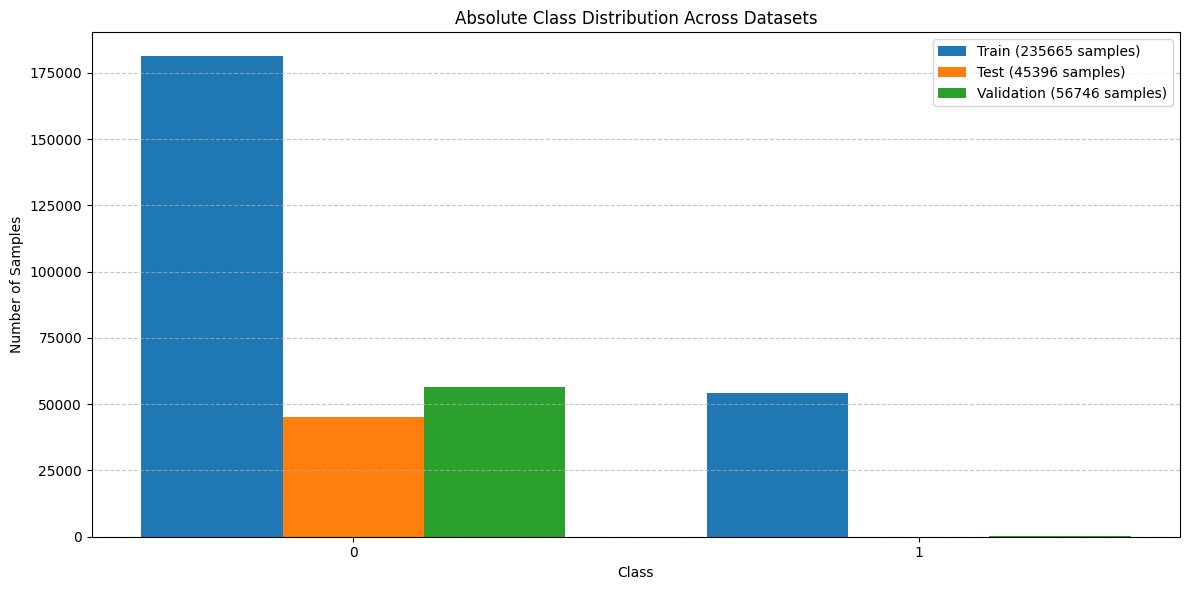

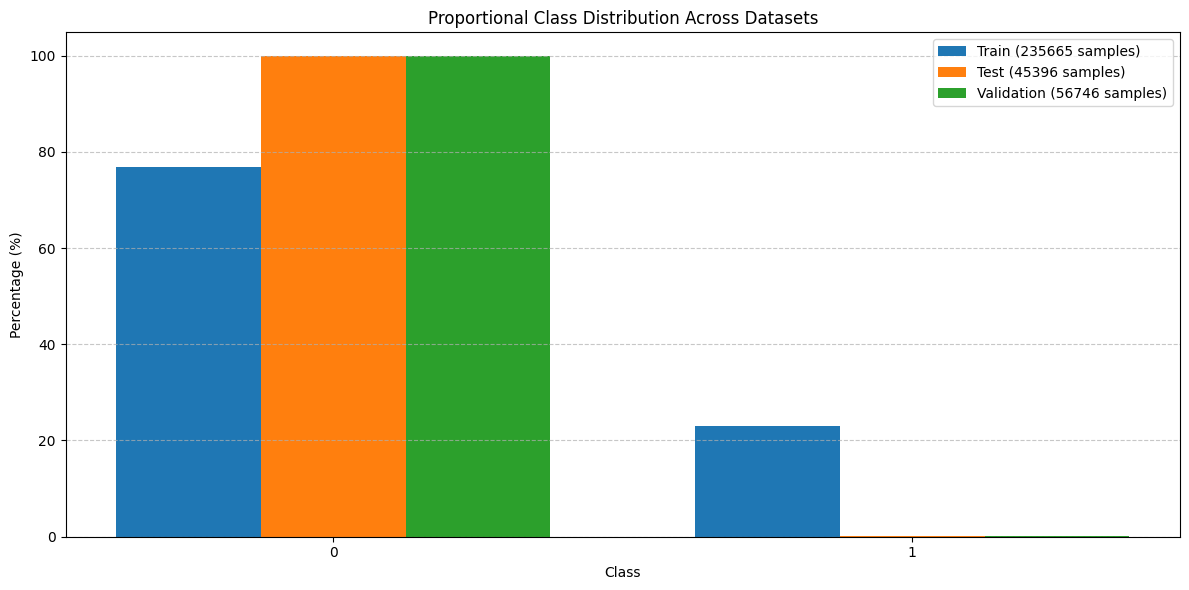

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from collections import Counter
import pandas as pd
from torch.utils.data import DataLoader

# Assuming you've already created your dataloaders as follows:
# train_loader, valid_loader, test_loader = get_dataloaders_fraud(...)

def visualize_dataset_distributions(train_loader, valid_loader, test_loader):
    """
    Create and display visualizations comparing the class distributions across datasets.
    """
    # Extract labels from each DataLoader
    def extract_labels(loader):
        labels = []
        for _, batch_labels in loader:
            labels.extend(batch_labels.cpu().numpy())
        return labels
    
    train_labels = extract_labels(train_loader)
    test_labels = extract_labels(test_loader)
    valid_labels = extract_labels(valid_loader) if valid_loader is not None else []
    
    # Count instances of each class
    train_counts = Counter(train_labels)
    test_counts = Counter(test_labels)
    valid_counts = Counter(valid_labels) if valid_loader is not None else {}
    
    # Convert to DataFrame for easier plotting
    df = pd.DataFrame({
        'Class': sorted(set(list(train_counts.keys()) + list(test_counts.keys()) + list(valid_counts.keys()))),
    })
    
    # Add counts for each dataset
    for cls in df['Class']:
        df.loc[df['Class'] == cls, 'Train Count'] = train_counts.get(cls, 0)
        df.loc[df['Class'] == cls, 'Test Count'] = test_counts.get(cls, 0)
        if valid_loader is not None:
            df.loc[df['Class'] == cls, 'Validation Count'] = valid_counts.get(cls, 0)
    
    # Calculate percentages
    train_total = len(train_labels)
    test_total = len(test_labels)
    valid_total = len(valid_labels) if valid_loader is not None else 0
    
    df['Train %'] = df['Train Count'] / train_total * 100
    df['Test %'] = df['Test Count'] / test_total * 100
    if valid_loader is not None:
        df['Validation %'] = df['Validation Count'] / valid_total * 100
    
    # Print summary
    print("\n--- Dataset Distribution Summary ---")
    print(f"Total samples in training set: {train_total}")
    if valid_loader is not None:
        print(f"Total samples in validation set: {valid_total}")
    print(f"Total samples in test set: {test_total}")
    print("\nClass distribution:")
    print(df.to_string(index=False))
    
    # Plot absolute counts
    plt.figure(figsize=(12, 6))
    width = 0.25
    x = np.arange(len(df['Class']))
    
    plt.bar(x - width, df['Train Count'], width=width, label=f'Train ({train_total} samples)')
    plt.bar(x, df['Test Count'], width=width, label=f'Test ({test_total} samples)')
    if valid_loader is not None:
        plt.bar(x + width, df['Validation Count'], width=width, label=f'Validation ({valid_total} samples)')
    
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.title('Absolute Class Distribution Across Datasets')
    plt.xticks(x, [f'{int(c)}' for c in df['Class']])
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('class_distribution_absolute.png')
    plt.show()
    
    # Plot percentages
    plt.figure(figsize=(12, 6))
    
    plt.bar(x - width, df['Train %'], width=width, label=f'Train ({train_total} samples)')
    plt.bar(x, df['Test %'], width=width, label=f'Test ({test_total} samples)')
    if valid_loader is not None:
        plt.bar(x + width, df['Validation %'], width=width, label=f'Validation ({valid_total} samples)')
    
    plt.xlabel('Class')
    plt.ylabel('Percentage (%)')
    plt.title('Proportional Class Distribution Across Datasets')
    plt.xticks(x, [f'{int(c)}' for c in df['Class']])
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('class_distribution_percentage.png')
    plt.show()
    
    return df

# Call the function with your dataloaders
df = visualize_dataset_distributions(train_loader, valid_loader, test_loader)

In [7]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from net import FraudNet  # Import fraud detection model
import pandas as pd

# Dynamically determine input size from dataset
df = pd.read_csv(DATASET_PATH)
input_size = df.shape[1] - 1  
print(f"Detected input size: {input_size}")

# Initialize Model
model = FraudNet(input_size=input_size).to(DEVICE)

# Loss Function (No weight balancing since using SMOTE)
criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Call `train.py` instead of writing the training loop here

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
optimizer, mode='max', patience=3, verbose=True
)

train_loss_list, train_metrics_list, valid_metrics_list, test_metrics = train_model(
    model, num_epochs, train_loader, valid_loader, test_loader, optimizer,
    criterion, DEVICE, scheduler=scheduler , stochastic=False
)

# plot...

# Save the trained model
best_model_path = "best_model.pth"
model.load_state_dict(torch.load(best_model_path))
print("Loaded best model from training phase.")

# Save the best model explicitly at a clear location for future usage
final_model_path = "./best_fraud_model.pth"
torch.save(model.state_dict(), best_model_path)
print(f"Final best model saved explicitly at {final_model_path}")

# Evaluate model
print("Evaluating Model on Test Set...")
evaluate_model(model, test_loader, DEVICE)

Detected input size: 30


/home/nahear/Thesis/NVFlare/nvflare_example/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Starting Training...
[Epoch 1, Batch 1] Loss: 0.7062
[Epoch 1, Batch 369] Loss: 0.1822
[Epoch 1, Batch 737] Loss: 0.2004
[Epoch 1, Batch 1105] Loss: 0.0930
[Epoch 1, Batch 1473] Loss: 0.1184
[Epoch 1, Batch 1841] Loss: 0.0828
[Epoch 1, Batch 2209] Loss: 0.0823
[Epoch 1, Batch 2577] Loss: 0.0204
[Epoch 1, Batch 2945] Loss: 0.1973
[Epoch 1, Batch 3313] Loss: 0.0767
[Epoch 1, Batch 3681] Loss: 0.0441
Epoch 1/10: Train Acc: 97.93% | Train Precision: 97.87% | Train Recall: 93.04% | Train F1-score: 95.39% | Train AUC-PR: 99.23%
Valid Acc: 99.36% | Valid Precision: 19.55% | Valid Recall: 91.49% | Valid F1-score: 32.21% | Valid AUC-PR: 70.17%
Time Elapsed: 0.98 minutes
Model improved. Saving best model.
[Epoch 2, Batch 1] Loss: 0.0443
[Epoch 2, Batch 369] Loss: 0.0398
[Epoch 2, Batch 737] Loss: 0.1326
[Epoch 2, Batch 1105] Loss: 0.0942
[Epoch 2, Batch 1473] Loss: 0.0665
[Epoch 2, Batch 1841] Loss: 0.0455
[Epoch 2, Batch 2209] Loss: 0.1228
[Epoch 2, Batch 2577] Loss: 0.0406
[Epoch 2, Batch 2945

{'accuracy': 99.74667371574589,
 'precision': 38.857142857142854,
 'recall': 89.47368421052632,
 'f1_score': 54.18326693227091,
 'auc_roc': 97.32562595809912,
 'auc_pr': 82.90533665903196}

[[-12.195243]
 [-11.159241]
 [-18.927105]
 ...
 [-17.324268]
 [-10.148925]
 [ -9.344525]]

Confusion Matrix:
[[45262    58]
 [    8    68]]


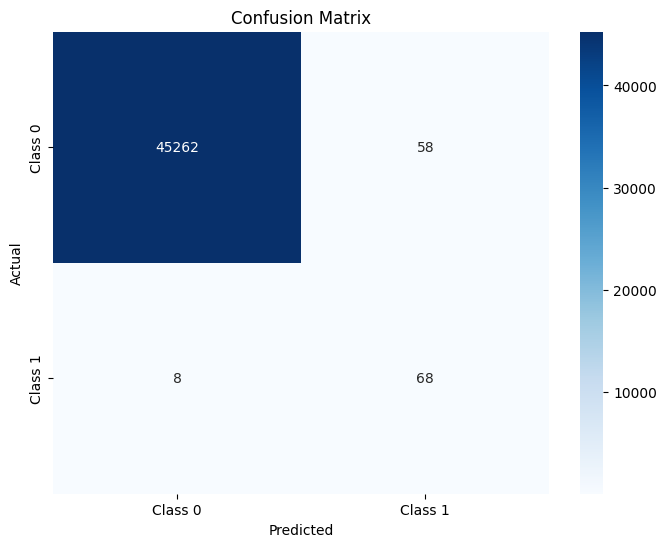

In [8]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

x_test = [x for x, y in test_loader]
x_test_tensor = torch.cat(x_test, dim=0).cuda()
y_test = [y for x, y in test_loader]

y_test_tensor = torch.cat(y_test, dim=0)
y_test_numpy = y_test_tensor.detach().cpu().numpy()

# Get predictions from model
with torch.no_grad():
    predictions = model(x_test_tensor)
    y_pred_numpy = predictions.detach().cpu().numpy()

print(y_pred_numpy)
y_pred_numpy = (y_pred_numpy > 0.999).astype(int)

# Now both should be discrete class labels
cm = confusion_matrix(y_test_numpy, y_pred_numpy)
print("")
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix (optional but recommended)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [9]:
print(test_metrics)

{'accuracy': 99.74667371574589, 'precision': 38.857142857142854, 'recall': 89.47368421052632, 'f1_score': 54.18326693227091, 'auc_roc': 97.32562595809912, 'auc_pr': 82.90533665903196}
